In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy as sp
import matplotlib.pyplot as plt

np.random.seed(1234)
# read data
df = pd.read_csv('retail_price.csv')
index = ['product_category_name', 'product_id']
column_min = ['unit_price', 'product_score', 'freight_price', 'product_weight_g', 'comp_1', 'ps1', 'comp_2', 'ps2', 'comp_3', 'ps3']
# column_max = []
column_sum = ['customers']

table_min = pd.pivot_table(df, values=column_min, index=index,  aggfunc=np.min)
# table_min = pivot_table(df, values='D', index=index,  aggfunc=np.max)
table_sum = pd.pivot_table(df, values=column_sum, index=index, aggfunc=np.sum)
table = table_min.merge(table_sum, on=index,how='left')
table

# Selling & Buying & Rating & Probability of buying
product_category = ['bed_bath_table', 'computers_accessories', 'consoles_games', 'cool_stuff', 'furniture_decor']

selling = {}
for category in product_category:
    selling[category] = (table.loc[category]['unit_price'].values)

# we set the margin as a uniform % 
buying = {}
for category in product_category:
    buying[category] = selling[category] * np.random.uniform(0.6,0.7, size = len(selling[category]))


rating = {}
for category in product_category:
    rating[category] = (table.loc[category]['product_score'].values)
MAX_RATING = 5.

# Customers
n_customers = {}
for category in product_category:
    n_customers[category] = (table.loc[category]['customers'].sum())

weights = {}
for category in product_category:
    weights[category] = (table.loc[category]['product_weight_g'].values)

softmax={}
for category in product_category:
    softmax[category] = (np.exp(-selling[category]*(MAX_RATING - rating[category]) / 100) 
              / np.sum(np.exp(-selling[category]*(MAX_RATING - rating[category])/100)))

SHIPPING_COST = (table['freight_price'] / table['product_weight_g']).groupby('product_category_name').agg('mean').to_dict()
MARKET_CUSTOMERS = {category: n_customers[category] / np.random.uniform(0.4,0.8) for category in product_category}

print("Buying prices ", buying)
print("RRP ", selling)
print("Product ratings ", rating)
print("Weights ", weights)

Buying prices  {'bed_bath_table': array([ 24.29552232,  49.00360491,  54.6563085 ,  29.96037386,
       110.78392988]), 'computers_accessories': array([41.61372347, 48.89365655, 90.44449434, 79.66454029, 53.05125824,
       95.30368088]), 'consoles_games': array([12.9369803 , 13.30009124]), 'cool_stuff': array([57.53073324, 74.48574951, 19.35552875, 87.78511965, 50.93210844]), 'furniture_decor': array([23.70489318, 48.10966192, 22.01052454, 51.95448642])}
RRP  {'bed_bath_table': array([ 39.24      ,  74.        ,  84.9       ,  44.15444444,
       163.3987097 ]), 'computers_accessories': array([ 66.34214286,  77.9       , 132.97      , 114.4911538 ,
        77.155     , 149.9       ]), 'consoles_games': array([19.9, 19.9]), 'cool_stuff': array([ 85.70428571, 116.9275    ,  29.5       , 134.99      ,
        84.6925    ]), 'furniture_decor': array([35.        , 69.9       , 34.58117647, 78.53571429])}
Product ratings  {'bed_bath_table': array([4. , 3.9, 3.3, 4.2, 4.4]), 'computers_acces

Text(0, 0.5, 'Product Category')

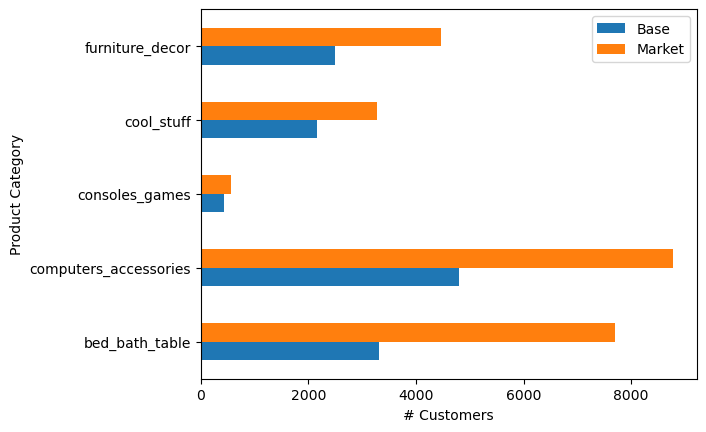

In [2]:
pd.DataFrame([n_customers, MARKET_CUSTOMERS], index = ['Base', 'Market']).T.plot.barh()
plt.xlabel('# Customers')
plt.ylabel('Product Category')

# Given unlimited inventory, when is our business efficient?

In [14]:
def run_model():
    m = gp.Model()

    #BIGNUM = 1e6 # sum(n_customers.values())

    # decision variables
    sold = {}
    discount = {}
    free_shipping = {}
    transport_multiplier = {}
    vars = {
        'sold':sold, 'discount':discount, 'free_shipping':free_shipping,
    }

    # initialising decision variables
    for category in product_category:
        I = range(len(selling[category]))
        sold[category] = m.addVars(I,vtype = GRB.INTEGER)
        discount[category] = m.addVars(I,vtype=GRB.CONTINUOUS, lb=0, ub=1)
        free_shipping[category] = m.addVars(I,  vtype = GRB.BINARY)
        transport_multiplier[category] = m.addVar(vtype = GRB.INTEGER)

    # amount sold and extra customers
    captured_customers = lambda category,i: (
        MARKET_CUSTOMERS[category] * (FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i])
    )
    amount_sold  = lambda category,i: softmax[category][i]* (n_customers[category] + captured_customers(category,i))

    # objective function
    m.setObjective(
        gp.quicksum(gp.quicksum(sold[category][i] * selling[category][i] * (1 - discount[category][i]) 
                                - sold[category][i] * buying[category][i]
                                - sold[category][i] * SHIPPING_COST[category] * weights[category][i] * free_shipping[category][i]
                    for i in range(len(selling[category]))) 
                    - BULK_PURCHASE_COST * transport_multiplier[category] for category in product_category),
        GRB.MAXIMIZE
    )

    # Can't store past inventory space
    m.addConstrs( gp.quicksum(sold[category][i] for i in range(len(selling[category]))) <= INVENTORY_SPACE 
                for category in product_category)

    # Can't buy more than the budget
    m.addConstr(gp.quicksum( gp.quicksum(sold[category][i] * buying[category][i] for i in range(len(selling[category]))) 
                            for category in product_category) <= BUDGET)

    for category in product_category:
        # If a product is stocked, is_chosen is set to be 1 [Change to BIGNUM to remove dependencies on n_customers]
        # How much we can sell depends on number of customers [Removed is_chosen]
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                    for i in range(len(selling[category])))
        m.addConstrs((FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i]) <= 1 for i in range(len(selling[category])))
        m.addConstrs(transport_multiplier[category] >= (1 / BULK_WEIGHT) * gp.quicksum(sold[category][i] * weights[category][i]
                                                                    for i in range(len(selling[category])))
                                                                    for category in product_category)

    m.params.NonConvex = 2
    m.optimize()
    data = {}
    for category in product_category:
        data[category] = {}
        for v in vars:
            data[category][v] = [a.X for a in vars[v][category].values()]
        data[category]['transport_units'] = transport_multiplier[category].X
        data[category]['captured_customers'] = [captured_customers(category, i).getValue() for i in range(len(selling[category]))]
        data[category]['total_sold'] = [amount_sold(category,i).getValue() for i in range(len(selling[category]))]
    
    objective = data['objective'] = m.getObjective().getValue()

    return m,objective,data


In [21]:
budgets = np.logspace(4, 10, num=50)
INVENTORY_SPACE = 1e6
FREE_SHIPPING_FACTOR = 0.2
BULK_PURCHASE_COST = 1e2
BULK_WEIGHT = 1e4
DISCOUNT_FACTOR = 2
results = []

for b in budgets:
    BUDGET = b
    m,objective,data = run_model()
    results.append({
        'budget' : b,
        'model' : m,
        'objective' : objective,
        'data':data
    })

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12600K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 75 rows, 71 columns and 289 nonzeros
Model fingerprint: 0x89b6d8de
Model has 44 quadratic objective terms
Variable types: 22 continuous, 49 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e-02, 4e+03]
  Objective range  [7e+00, 1e+02]
  QObjective range [8e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective -0.0000000
Presolve removed 65 rows and 42 columns
Presolve time: 0.00s
Presolved: 17 rows, 34 columns, 74 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 5 continuous, 29 integer (2 binary)

Root relaxation: objective 5.564294e+03, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node 

In [27]:
profits = [(r['objective'] - r['budget'])/r['budget'] for r in results]
profits

[-0.44615265700607504,
 -0.44437077036571343,
 -0.446003783782137,
 -0.44504513939841434,
 -0.4452335982247909,
 -0.4453862259120776,
 -0.4456626532830273,
 -0.4464235281662222,
 -0.4528330253194993,
 -0.459977112228929,
 -0.47061090522714516,
 -0.4988073668367494,
 -0.532151471017538,
 -0.5797609111333869,
 -0.6572843884412486,
 -0.7414962986600755,
 -0.8049951820770797,
 -0.8529055245474805,
 -0.8890448711005475,
 -0.9163049329957738,
 -0.9368678060876612,
 -0.9523786281456242,
 -0.9640786274520787,
 -0.972904077403054,
 -0.9795612202623872,
 -0.9845827830490728,
 -0.988370608149637,
 -0.9912278101008914,
 -0.9933830318372477,
 -0.9950087414692964,
 -0.9962350337635659,
 -0.9971600407644102,
 -0.9978577846510913,
 -0.998384101242162,
 -0.9987811081659403,
 -0.9990805752551445,
 -0.9993064668760336,
 -0.9994768596378008,
 -0.9996053889437945,
 -0.9997023401424714,
 -0.9997754715956622,
 -0.9998306355288445,
 -0.999872246345961,
 -0.9999036338849051,
 -0.99992730988238,
 -0.99994516897

# increasing number of customers?

In [ ]:
n_customers = {n_customers[category]*10 for category in n_customers}
MARKET_CUSTOMERS = {MARKET_CUSTOMERS[category]*10 for category in n_customers}